MIT License

Copyright (c) 2021 Taiki Miyagawa and Akinori F. Ebihara

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.


# Plot Speed-Accuracy Tradeoff (SAT) Curve of Validation dataset

In [1]:
from __future__ import absolute_import, division, print_function

import os, sys, glob
from itertools import zip_longest
import optuna
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatter, ScalarFormatter, NullFormatter
import numpy as np
import tensorflow as tf

from datasets.data_processing import read_tfrecords_nosaic_mnist,\
    decode_feat, sequential_slice, sequential_concat
from models.backbones_ti import LSTMModelLite
from models.optimizers import get_optimizer
from models.losses import get_gradient_lstm
from utils.misc import load_yaml, set_gpu_devices, fix_random_seed,\
    restrict_classes, extract_positive_row, add_max_to_diag
from utils.performance_metrics import multiplet_sequential_confmx,\
    llr_sequential_confmx,\
    truncated_MSPRT, threshold_generator,\
    calc_llrs, calc_oblivious_llrs, threshold_generator, thresh_sanity_check,\
    NP_test,\
    get_LLR_min_and_max, get_linspace, threshold_generator_with_values,\
    seqconfmx_to_metrics

# User-defined params

In [2]:
# Dataset

dataname = "NMNIST-H"
duration = 20
order_sprt = 15
oblivious = True
name_model = "./data-directory/trained_models/TI_NMNIST-H/" # Trained with 15-th order M-TANDEMwO.
tfr_train = "./data-directory/nosaic_mnist-h_feat_train.tfrecords"
tfr_test = "./data-directory/nosaic_mnist-h_feat_test.tfrecords" 

# dataname = "NMNIST-100f"
# duration = 100
# order_sprt = 25
# oblivious = False
# name_model = "./data-directory/trained_models/TI_NMNIST-100f/" # Trained with the 25-th order TANDEM.
# tfr_train = "./data-directory/nosaic_mnist-100f-15pix_feat_train.tfrecords"
# tfr_test = "./data-directory/nosaic_mnist-100f-15pix_feat_test.tfrecords" 

In [3]:
# User-defined
gpu = 0 # Which GPU to be used
num_thresh = 200 # Total number of thresholds to be used to plot the SAT curve
batch_thresh = 5 # Memory consuming!! How many thresholds to be parallely computed at once. < 10 is recommended
sparsity = "linspace" # SPRT's threshold generation method."linspace" or "logspace".
class_plot = 10 # Which class' recall to be plotted. 
    # If class_plot = 3, then classwise recall of class 3 is plotted (zero base). 
    # If class_plot = num classes, then the macro-averaged recall (averaged per-class accuracy) is plotted.
    # If class_plot = num classes + 1, then the micro-averaged recall is plotted.

batch_size = 100 # Must be a divisor of the num of test datapoints. Memory consumption << batch_thresh.

assert num_thresh % batch_thresh == 0 # Make sure

In [4]:
# Others
feat_dim = 128
num_classes = 10
width_lstm = feat_dim 
dropout = 0.
activation = "tanh" 
num_trainset = 50000

# 0. Start calc logits and LLRs

In [5]:
# Which GPU to be used
set_gpu_devices(gpu)

In [6]:
# Load data
##################################
# Reed tfr and make 
parsed_image_dataset_train, parsed_image_dataset_valid, parsed_image_dataset_test = \
    read_tfrecords_nosaic_mnist(
        record_file_train=tfr_train, 
        record_file_test=tfr_test, 
        batch_size=batch_size,
        num_trainset=num_trainset,
        shuffle_buffer_size=2000)

# Model
##################################
model = LSTMModelLite(
    num_classes=num_classes, 
    width_lstm=width_lstm, 
    dropout=dropout, 
    activation=activation) 

# Restore parameters
#################################
ckpt = tf.train.Checkpoint(net=model)
ckpt_manager_restore = tf.train.CheckpointManager(ckpt,
    name_model, max_to_keep=3)
ckpt.restore(ckpt_manager_restore.latest_checkpoint)
print("Restored latest model\n{}".format(
    ckpt_manager_restore.latest_checkpoint)) 

# Evaluaton loop
##################################
for iter_b, feats in enumerate(parsed_image_dataset_valid):
    cnt = iter_b + 1

    # Decode features and binarize classification labels
    x_batch, y_batch = decode_feat(feats, duration, feat_dim,
    dtype_feat=tf.float32, dtype_label=tf.int32) 

    x_slice, y_slice = sequential_slice(x_batch, y_batch, order_sprt)

    # Calc logits 
    if iter_b == 0:
        ls_logits = []
        ls_labels = []

    # Calc loss
    logits_tmp = model(x_slice, False)
    logits_tmp, _ = sequential_concat(logits_tmp, y_slice, duration) 

    ls_logits.append(logits_tmp)
    ls_labels.append(y_batch)

    # Verbose
    if ((iter_b+1)%10 == 0) or (iter_b == 0):
        sys.stdout.write("\rEvaluation Iter: {:3d}".format(iter_b+1))
        sys.stdout.flush()

print()
logits_all = tf.concat(ls_logits, axis=0)
labels_all = tf.concat(ls_labels, axis=0)

Restored latest model
/data/t-miyagawa/sprt_multiclass/nosaic_mnist-1000f/ckptlogs/100f15p_E_ver20201207_stat/__20201221_151111721/ckpt_step5000_macrec0.92740-14
Evaluation Iter: 100


In [7]:
# Calc LLRs
if oblivious:
    llrs_all = calc_oblivious_llrs(logits_all)
else:
    llrs_all = calc_llrs(logits_all)

# Used to generate thresholds
start, stop = get_LLR_min_and_max(llrs_all) # A bit memory consuming. Proportional to the dataset size. Can be modified.
values = get_linspace(start, stop, num_thresh, sparsity)

In [8]:
# Mini-batch threshold processing to save GPU memory 
ls_confmx_th = []
ls_mht_th = []
ls_vht_th = []
ls_trt_th = []
for i in range(num_thresh // batch_thresh):
    # Generate Thresholds for SPRT
    idx = batch_thresh * i
    itr_values = values[idx : idx + batch_thresh]
    itr_thresh = threshold_generator_with_values(itr_values, duration, num_classes) # memory consuming
    thresh_sanity_check(itr_thresh)
    
    # Confusion matrix of SPRT, mean/var hitting time, 
    # and truncation rate
    ###########################
    tmp_confmx_th, tmp_mht_th, tmp_vht_th, tmp_trt_th = \
        truncated_MSPRT(
            llr_mtx=llrs_all,
            labels_concat=labels_all,
            thresh_mtx=itr_thresh) # Super GPU memory super-consuming if batch_thresh is large.
        # (num thresh, num classes, num classes)
        # (num thresh,)
        # (num thresh,)
        # (num thresh,)
    ls_confmx_th.append(tmp_confmx_th)
    ls_mht_th.append(tmp_mht_th)
    ls_vht_th.append(tmp_vht_th)
    ls_trt_th.append(tmp_trt_th)

confmx_th = tf.concat(ls_confmx_th, axis=0)
mht_th = tf.concat(ls_mht_th, axis=0)
vht_th = tf.concat(ls_vht_th, axis=0)
trt_th = tf.concat(ls_trt_th, axis=0)

In [9]:
# SPRT results
###########################
# Extract recalls (sensitivities)
dc_mtr = seqconfmx_to_metrics(confmx_th)

# Output
ls_sns = dc_mtr["SNS"].numpy()
    # (num thresh, num classes + 2)
    # [[recall of class 0, 1, 2, ..., recall of the last class, balanced accuracy, accuracy], ...]

ls_mht = mht_th.numpy()
    # (num thresh,)
ls_vht = vht_th.numpy()
    # (num thresh,)
ls_trt = trt_th.numpy()
    # (num thresh,)
    
# NPT confmx
############################
seqconfmx_llr = NP_test(llrs_all, labels_all)
    # (duration, num classes, num classes)
    
# NPT results
###########################
#ls_metrics_llr = seqconfmx_to_list_metrics(seqconfmx_llr) # ===== time consuming ===== #
dc_mtr_llr = seqconfmx_to_metrics(seqconfmx_llr)

# Output
ls_sns_NPT = dc_mtr_llr["SNS"].numpy()
    # (duration, num classes + 2)
    # [[recall of class 0, 1, 2, ..., recall of the last class, macro-averaged recall, micro-averaged recall], ...]

# 1. Plot SAT (Speed-Accuracy Tradeoff) Curve
We use`ls_mht`,  `ls_vht`, `ls_trt`, `ls_sns`, and `ls_sns_NPT` (computed above).

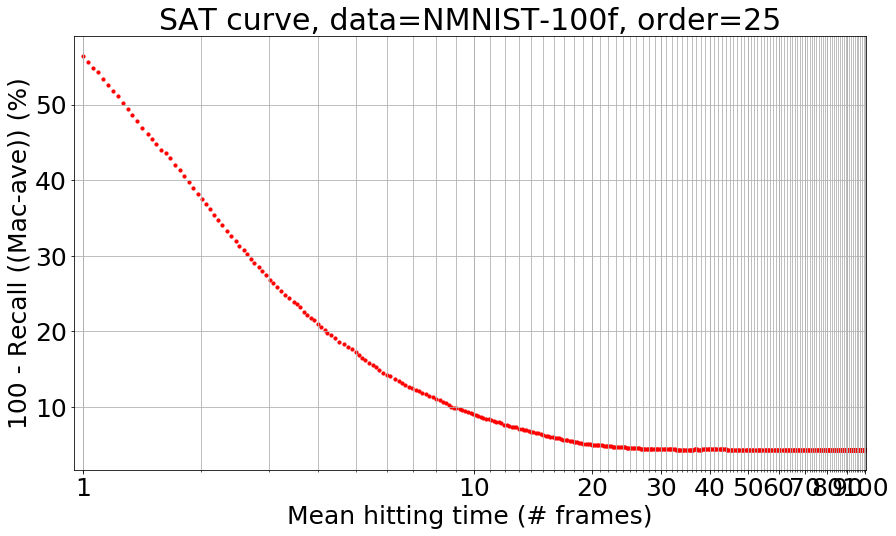

In [12]:
# Parameters
x = ls_mht
y = 100 * (1 - ls_sns[:, class_plot]) # macro-averaged recall

title = "SAT curve, data={}, order={}".format(dataname, order_sprt)
xlabel = "Mean hitting time (# frames)"
if class_plot < num_classes:
    _tmp = "(Class={})".format(class_plot)
elif class_plot == num_classes:
    _tmp = "(Mac-ave)"
elif class_plot == num_classes + 1:
    _tmp = "(Mic-ave)"
else:
    raise ValueError
ylabel = "100 - Recall ({}) (%)".format(_tmp)


# Size
plt.rcParams["font.size"] = 25
fig, ax = plt.subplots(figsize=(13,8))
fig.patch.set_facecolor('white')
# Scale
ax.set_xscale('log')
# Grid
major_ticks = np.arange(0, duration + 1, 10)
major_ticks[0] += 1
minor_ticks = np.arange(0, duration + 1, 1)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_xticklabels(['0, 10, 20, 30, 40, 50'])
for axis in [ax.xaxis, ax.yaxis]: # ?
    axis.set_major_formatter(ScalarFormatter())
    axis.set_minor_formatter(NullFormatter())

# Plot
plt.scatter(
    x, y, 
    s=10, 
    color="red", 
    marker='o', 
    vmin=None, 
    vmax=None, 
    alpha=None, 
    linewidths=None,
    edgecolors=None
    )

plt.ylabel(ylabel)        
plt.xlabel(xlabel)
plt.grid(which='both')
#plt.legend(loc=None, fontsize='15')
plt.title(title)
plt.xlim(0.95, duration+0.3)# 1stO, 19thO
#plt.xlim(3.95, duration+0.3)# 1stO, 19thO
#plt.ylim(99.08, 99.65) # 1stO, 19thO
#plt.xlim(4.-0.3, duration+0.3)# 1stO, 19thO
#plt.ylim(70.08, 80.65) # 1stO, 19thO
plt.tight_layout()

# Save figure
#plt.savefig(***)

## 1-1. SPRT vs NPT

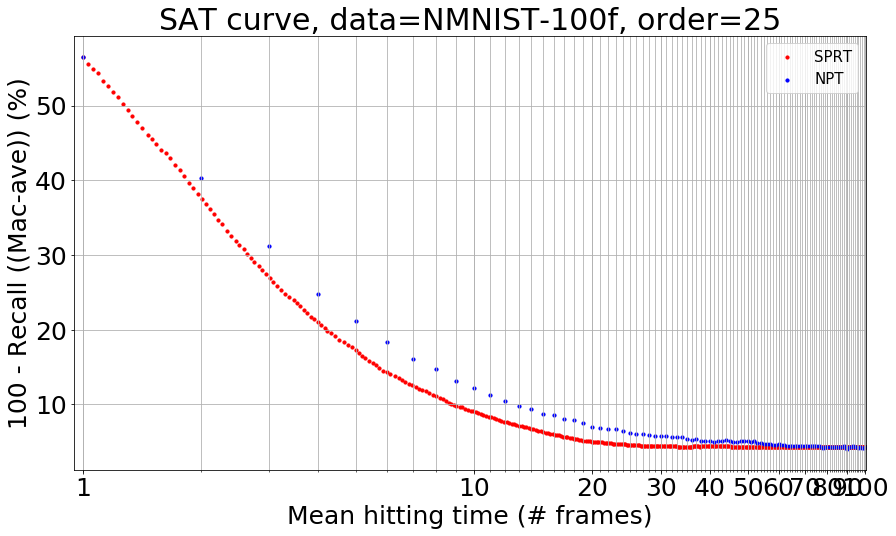

In [13]:
# Plot NPT vs SPRT
###############################
# Parameters
x = ls_mht
y = 100 * (1 - ls_sns[:, class_plot])
x_np = np.array([i + 1 for i in range(duration)])
y_np = 100 * (1 - ls_sns_NPT[:, class_plot])
label = "SPRT"
label_np = "NPT"
title = "SAT curve, data={}, order={}".format(dataname, order_sprt)
xlabel = "Mean hitting time (# frames)"
if class_plot < num_classes:
    _tmp = "(Class={})".format(class_plot)
elif class_plot == num_classes:
    _tmp = "(Mac-ave)"
elif class_plot == num_classes + 1:
    _tmp = "(Mic-ave)"
else:
    raise ValueError
ylabel = "100 - Recall ({}) (%)".format(_tmp)



# Size
plt.rcParams["font.size"] = 25
fig, ax = plt.subplots(figsize=(13,8))
# Scale
ax.set_xscale('log')
# Grid
major_ticks = np.arange(0, duration + 1, 10)
major_ticks[0] += 1
minor_ticks = np.arange(0, duration + 1, 1)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_xticklabels(['0, 10, 20, 30, 40, 50'])
for axis in [ax.xaxis, ax.yaxis]: # ?
    axis.set_major_formatter(ScalarFormatter())
    axis.set_minor_formatter(NullFormatter())

# Plot SPRT
plt.scatter(
    x, y, 
    s=10, 
    color="red", 
    marker='o', 
    vmin=None, 
    vmax=None, 
    alpha=None, 
    linewidths=None,
    edgecolors=None,
    label="SPRT"
    )

# Plot NPT
plt.scatter(
    x_np, y_np, 
    s=10, 
    color="blue", 
    marker='o', 
    vmin=None, 
    vmax=None, 
    alpha=None, 
    linewidths=None,
    edgecolors=None,
    label="NPT"
    )

plt.ylabel(ylabel)        
plt.xlabel(xlabel)
plt.grid(which='both')
plt.legend(loc=1, fontsize='15')
plt.title(title)
plt.xlim(0.95, duration+0.3)
#plt.xlim(10.95, duration+0.3)
#plt.ylim(88., 99.7) # v1
#plt.ylim(95, 99.7) # v2
plt.tight_layout()

# Save figure
# plt.savefig(***)

# 2. Plot SAT Curve with Standard Deviation of Hitting Times

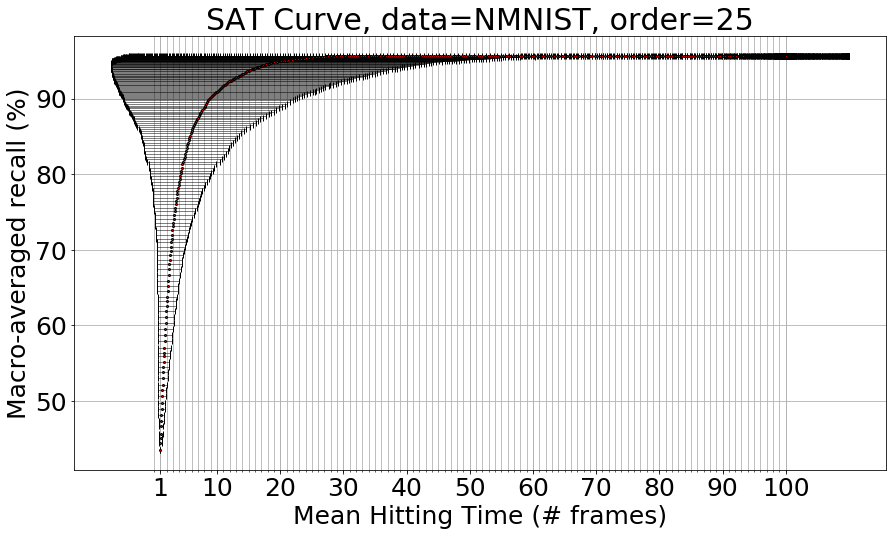

In [14]:
# Start plotting SP curve with variance
######################################
# Parameters
x = ls_mht
y = 100. * ls_sns[:, -2] # macro-averaged recall
xerr =  np.sqrt(ls_vht)
title = "SAT Curve, data=NMNIST, order={}".format(order_sprt)
xlabel = "Mean Hitting Time (# frames)"
ylabel = "Macro-averaged recall (%)"

# Size
plt.rcParams["font.size"] = 25
fig, ax = plt.subplots(figsize=(13,8))
fig.patch.set_facecolor('white')
# Scale
#ax.set_xscale('log')
# Grid
major_ticks = np.arange(0, duration + 1, 10)
major_ticks[0] += 1
minor_ticks = np.arange(0, duration + 1, 1)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_xticklabels(['0, 10, 20, 30, 40, 50'])
for axis in [ax.xaxis, ax.yaxis]: # ?
    axis.set_major_formatter(ScalarFormatter())
    axis.set_minor_formatter(NullFormatter())
    
# Plot
plt.errorbar(
    x, y, 
    xerr = xerr, 
    capsize=3, 
    fmt='o', 
    markersize=2, 
    ecolor='black', 
    markeredgecolor = "black", 
    color='red',
    elinewidth=0.5)

plt.ylabel(ylabel)        
plt.xlabel(xlabel)
plt.grid(which='both')
#plt.legend(loc=4, fontsize='15')
plt.title(title)
#plt.xlim(0.95, duration+0.3)
#plt.ylim(88., 99.7) # v1
#plt.ylim(95, 99.7) # v2
plt.tight_layout()

# Save figure
# plt.savefig(***)

# 3. Plot Trajectories of LLRs

The LLR matrix is defined as:
\begin{equation}
    \lambda(t) := 
    \begin{pmatrix}
    0                & \cdots &  \lambda_{1l}(t) & \cdots & \lambda_{1K}(t)\\
    \vdots           & \ddots &                  &        & \vdots \\
    -\lambda_{1l}(t) &        &                0 &        & \lambda_{kK}(t) \\
    \vdots           &        &                  & \ddots & \vdots \\
    -\lambda_{1K}(t) & \cdots & -\lambda_{kK}(t) & \cdots & 0
    \end{pmatrix} , 
\end{equation}
where
\begin{equation}
    \lambda_{kl}(t) := \log(\frac{p(X^{(1,t)}\,\,\,|y=k)}{p(X^{(1,t)}\,\,\,|y=l)})\,\,\, (k, l \in [K], K\in\mathbb{N}) .
\end{equation}
In the following, we give five different graphs to plot LLR matrices. 3-1 and 3-2 are used in our paper.

## 3-1 All LLR rows with minimum $l$  

- $\mathrm{min}_{l\neq k} \mathrm{LLR}_{k\, l}$

In [60]:
num_trj = 10
plot_classes = [] # optional: default=[]
shuffle = True

In [90]:
# Initialization
llrs_trj = llrs_all
labels_trj = labels_all

# Restrict classes (optional)
llrs_trj, labels_trj = restrict_classes(llrs_trj, labels_trj, plot_classes)

### Add max LLR to diag
llrs_trj = add_max_to_diag(llrs_trj)

### Extract min column: shape change (batch, duration, num classes num classes) -> (batch, duration, num classes)
llrs_trj = tf.reduce_min(llrs_trj, axis=3)

# Shuffle (optional)
if shuffle:
    idx_perm = np.random.permutation(labels_trj.shape[0]) # randomly take some LLRs
    llrs_trj = tf.constant(llrs_trj.numpy()[idx_perm], dtype=tf.float32)
    labels_trj = tf.constant(labels_trj.numpy()[idx_perm], dtype=tf.int32)
    
# Pick some out
llrs_trj = llrs_trj[:num_trj].numpy()
labels_trj = labels_trj[:num_trj].numpy()

In [91]:
# Color definitions
ls_color = [
    "red",
    "blue",
]
# ls_plotLabel =[
#     "min_l {LLR_k =yi l}",
#     "min_l {LLR_k!=yi l}",
# ]
ls_plotLabel =[
    "min column of the positive row",
    "min column of   a negative row",
] 

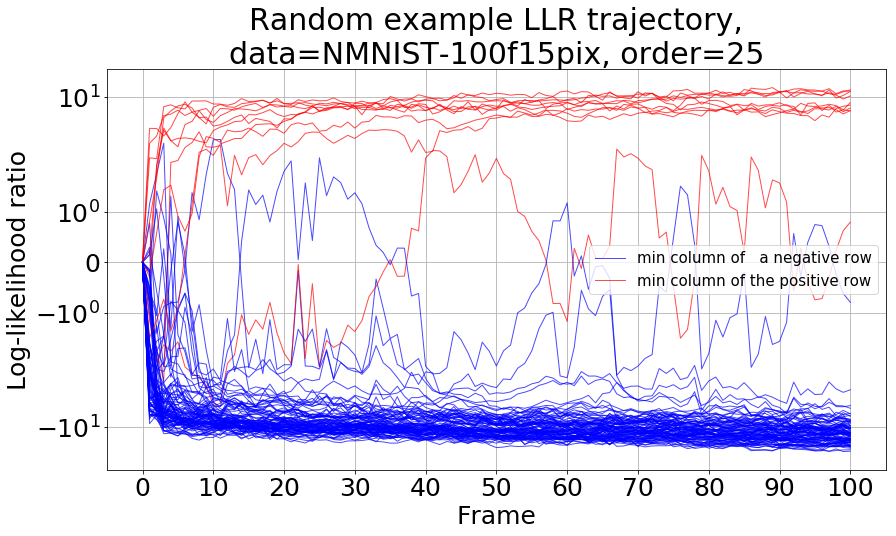

In [19]:
# Start plotting trajectory
######################################
# Parameters
x = [i for i in range(0, duration+1)]
title = "Random example LLR trajectory,\ndata=NMNIST-100f15pix, order={}".format(order_sprt)
xlabel = "Frame"
ylabel = "Log-likelihood ratio"

# Size
plt.rcParams["font.size"] = 25
plt.figure(figsize=(13,8)) 

# plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
#     [])

_tmp = set()
for itr_llrs, itr_label in zip(llrs_trj, labels_trj):
    itr_llrs = np.transpose(itr_llrs, [1, 0])
        # (num classes, duration)
    for itr_i, itr_trj in enumerate(itr_llrs):
        y = np.append(0, itr_trj)
        
        # Color and plot label
        if itr_i == itr_label:
            color = ls_color[0]
            if not (_tmp >= {ls_plotLabel[0]}):
                plot_label = ls_plotLabel[0]
                _tmp.add(plot_label)
            else:
                plot_label = None
        else:
            color = ls_color[1]
            if not (_tmp >= {ls_plotLabel[1]}):
                plot_label = ls_plotLabel[1]
                _tmp.add(plot_label)    
            else:
                plot_label = None
        
        # Plot
        plt.plot(
            x, y, 
            color=color, 
            marker='o', 
            linewidth=1, 
            markersize=0,
            label=plot_label,
            alpha=0.7
            )
        cnt += 1

plt.xlabel(xlabel)
plt.ylabel(ylabel)        
plt.yscale("symlog")
plt.grid(True)
plt.legend(fontsize='15')
plt.title(title)
plt.xticks([i for i in range(0, duration + 1)])
#plt.xlim(-0.1, 20.1)
plt.locator_params(axis='x', nbins=11)
plt.tight_layout()

# Save figure 
# plt.savefig(
#     "./traj_order{}.svg".format(order_sprt), 
#     format="svg", 
#     dpi=1200)

## 3-2 Positive LLR row with minimum $l$
- $\mathrm{min}_{l (\neq y_i)} \mathrm{LLR}_{y_{i}\, l}$

In [32]:
num_trj = 20
plot_classes = [] # optional: default=[]
shuffle = True

In [33]:
# Initialization
llrs_trj = llrs_all
labels_trj = labels_all

# Restrict classes (optional)
llrs_trj, labels_trj = restrict_classes(llrs_trj, labels_trj, plot_classes)
### Add max LLR to diag
llrs_trj = add_max_to_diag(llrs_trj)

### Extract positive rows: shape change -> (batch, duration, num classes)
llrs_trj = extract_positive_row(llrs_trj, labels_trj)

### Extract min column: shape change (batch, duration, num classes) -> (batch, duration)
llrs_trj = tf.reduce_min(llrs_trj, axis=2)

# Shuffle (optional)
if shuffle:
    idx_perm = np.random.permutation(labels_trj.shape[0]) # randomly take some LLRs
    llrs_trj = tf.constant(llrs_trj.numpy()[idx_perm], dtype=tf.float32)
    labels_trj = tf.constant(labels_trj.numpy()[idx_perm], dtype=tf.int32)
    
# Pick some up
llrs_trj = llrs_trj[:num_trj].numpy()
labels_trj = labels_trj[:num_trj].numpy()

In [34]:
# Color definitions
ls_color = [
    "magenta",
    "darkviolet",
    "royalblue",
    "cyan",
    "chartreuse",
    "red",
    "sienna", 
    "darkorange",
    "black", 
    "olive"
]
ls_plotLabel =[
    "min_l {LLR_yi=0 l}",
    "min_l {LLR_yi=1 l}",
    "min_l {LLR_yi=2 l}",
    "min_l {LLR_yi=3 l}",
    "min_l {LLR_yi=4 l}",
    "min_l {LLR_yi=5 l}",
    "min_l {LLR_yi=6 l}",
    "min_l {LLR_yi=7 l}",
    "min_l {LLR_yi=8 l}",
    "min_l {LLR_yi=9 l}",] 

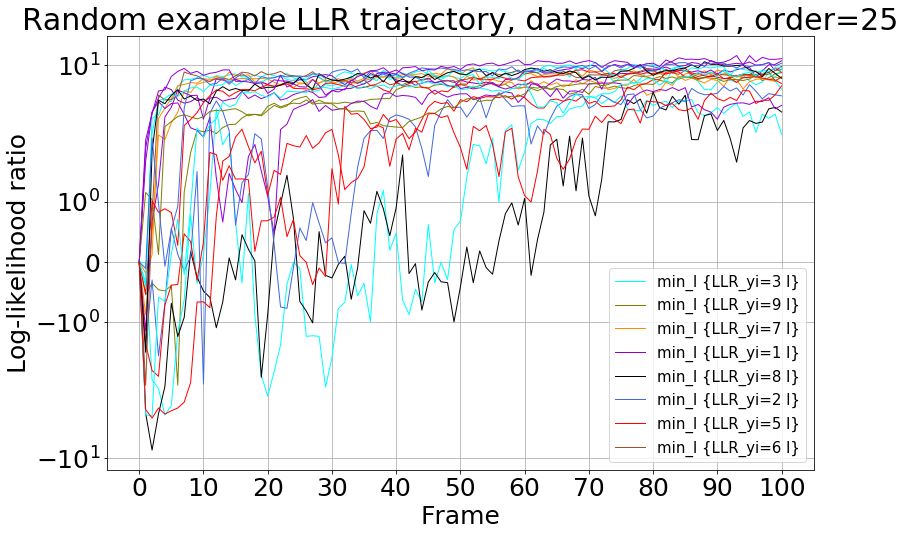

In [35]:
# Start plotting trajectory
######################################
# Parameters
x = [i for i in range(0, duration+1)]
title = "Random example LLR trajectory, data=NMNIST, order={}".format(order_sprt)
xlabel = "Frame"
ylabel = "Log-likelihood ratio"

# Size
plt.rcParams["font.size"] = 25
plt.figure(figsize=(13,8)) 

_tmp = set()
for itr_trj, itr_label in zip(llrs_trj, labels_trj):
    y = np.append(0, itr_trj)

    # Color
    color = ls_color[itr_label]

    # Label
    if _tmp >= {itr_label}:
        plot_label = None
    else:
        _tmp.add(itr_label)
        plot_label = ls_plotLabel[itr_label]

    # Plot
    plt.plot(
        x, y, 
        color=color, 
        marker='o', 
        linewidth=1, 
        markersize=0,
        label=plot_label
        )

plt.xlabel(xlabel)
plt.ylabel(ylabel)        
plt.yscale("symlog")
plt.grid(True)
plt.legend(fontsize='15')
plt.title(title)
plt.xticks([i for i in range(0, duration + 1, 10)])
#plt.xlim(-0.1, 20.1)

plt.tight_layout()

# Save figure 
# plt.savefig(
#     "./traj_order{}.svg".format(order_sprt), 
#     format="svg", 
#     dpi=1200)

## 3-3 All LLR rows with minimum $l  

- $\mathrm{min}_{l\neq k} \mathrm{LLR}_{k\, l}$ and $k=y_i$ only

In [20]:
num_trj = 20
plot_classes = [] # optional: default=[]
shuffle = True

In [21]:
# Initialization
llrs_trj = llrs_all
labels_trj = labels_all

# Restrict classes (optional)
llrs_trj, labels_trj = restrict_classes(llrs_trj, labels_trj, plot_classes)

### Add max LLR to diag
llrs_trj = add_max_to_diag(llrs_trj)

### Extract min column: shape change (batch, duration, num classes num classes) -> (batch, duration, num classes)
llrs_trj = tf.reduce_min(llrs_trj, axis=3)

# Shuffle (optional)
if shuffle:
    idx_perm = np.random.permutation(labels_trj.shape[0]) # randomly take some LLRs
    llrs_trj = tf.constant(llrs_trj.numpy()[idx_perm], dtype=tf.float32)
    labels_trj = tf.constant(labels_trj.numpy()[idx_perm], dtype=tf.int32)
    
# Pick some out
llrs_trj = llrs_trj[:num_trj].numpy()
labels_trj = labels_trj[:num_trj].numpy()

In [22]:
# Color definitions
ls_color = [
    "magenta",
    "darkviolet",
    "royalblue",
    "cyan",
    "chartreuse",
    "red",
    "sienna", 
    "darkorange",
    "black", 
    "olive"
]
ls_plotLabel =[
    "min_l LLR_yi=0 l",
    "min_l LLR_yi=1 l",
    "min_l LLR_yi=2 l",
    "min_l LLR_yi=3 l",
    "min_l LLR_yi=4 l",
    "min_l LLR_yi=5 l",
    "min_l LLR_yi=6 l",
    "min_l LLR_yi=7 l",
    "min_l LLR_yi=8 l",
    "min_l LLR_yi=9 l",] 

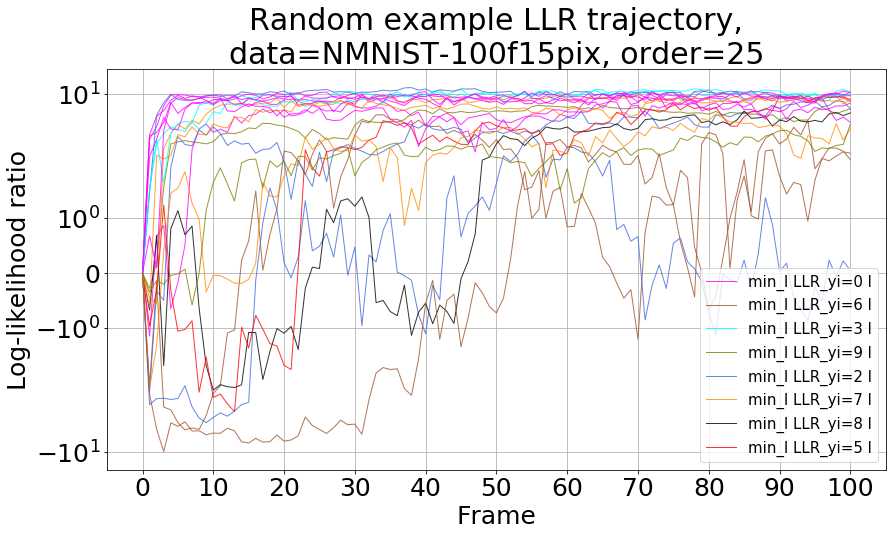

In [23]:
# Start plotting trajectory
######################################
# Parameters
x = [i for i in range(0, duration+1)]
title = "Random example LLR trajectory,\ndata=NMNIST-100f15pix, order={}".format(order_sprt)
xlabel = "Frame"
ylabel = "Log-likelihood ratio"

# Size
plt.rcParams["font.size"] = 25
plt.figure(figsize=(13,8)) 


_tmp = set()
for itr_llrs, itr_label in zip(llrs_trj, labels_trj):
    itr_llrs = np.transpose(itr_llrs, [1, 0])
        # (num classes, duration)
    for itr_i, itr_trj in enumerate(itr_llrs):
        y = np.append(0, itr_trj)
        
        # Color and plot label
        if itr_i == itr_label:
            color = ls_color[itr_label]
            if not (_tmp >= {ls_plotLabel[itr_label]}):
                plot_label = ls_plotLabel[itr_label]
                _tmp.add(plot_label)
            else:
                plot_label = None
        else:
            continue
        
        # Plot
        plt.plot(
            x, y, 
            color=color, 
            marker='o', 
            linewidth=1, 
            markersize=0,
            label=plot_label,
            alpha=0.8
            )
        cnt += 1

plt.xlabel(xlabel)
plt.ylabel(ylabel)        
plt.yscale("symlog")
plt.grid(True)
plt.legend(fontsize='15')
plt.title(title)
plt.xticks([i for i in range(0, duration + 1, 10)])
#plt.xlim(-0.1, 20.1)
plt.tight_layout()

# Save figure 
# plt.savefig(
#     "./traj_order{}.svg".format(order_sprt), 
#     format="svg", 
#     dpi=1200)

## 3-4 Positive LLR row

- $\mathrm{LLR}_{y_{i}\, l}$, where $l \neq y_i$

In [24]:
num_trj = 10
plot_classes = [0,4,6] # optional: default=[]
shuffle = True

In [25]:
# Initialization
llrs_trj = llrs_all
labels_trj = labels_all

# Restrict classes (optional)
llrs_trj, labels_trj = restrict_classes(llrs_trj, labels_trj, plot_classes)

### Extract positive rows: shape change -> (batch, duration, num classes)
llrs_trj = extract_positive_row(llrs_trj, labels_trj)

# Shuffle (optional)
if shuffle:
    idx_perm = np.random.permutation(labels_trj.shape[0]) # randomly take some LLRs
    llrs_trj = tf.constant(llrs_trj.numpy()[idx_perm], dtype=tf.float32)
    labels_trj = tf.constant(labels_trj.numpy()[idx_perm], dtype=tf.int32)

# Pick some up
llrs_trj = llrs_trj[:num_trj].numpy()
labels_trj = labels_trj[:num_trj].numpy()

In [26]:
# Color definitions
ls_color = [
    "magenta",
    "darkviolet",
    "royalblue",
    "cyan",
    "chartreuse",
    "red",
    "sienna", 
    "darkorange",
    "black", 
    "olive"
]
ls_plotLabel =[
    "LLR_yi=0 l",
    "LLR_yi=1 l",
    "LLR_yi=2 l",
    "LLR_yi=3 l",
    "LLR_yi=4 l",
    "LLR_yi=5 l",
    "LLR_yi=6 l",
    "LLR_yi=7 l",
    "LLR_yi=8 l",
    "LLR_yi=9 l",] 

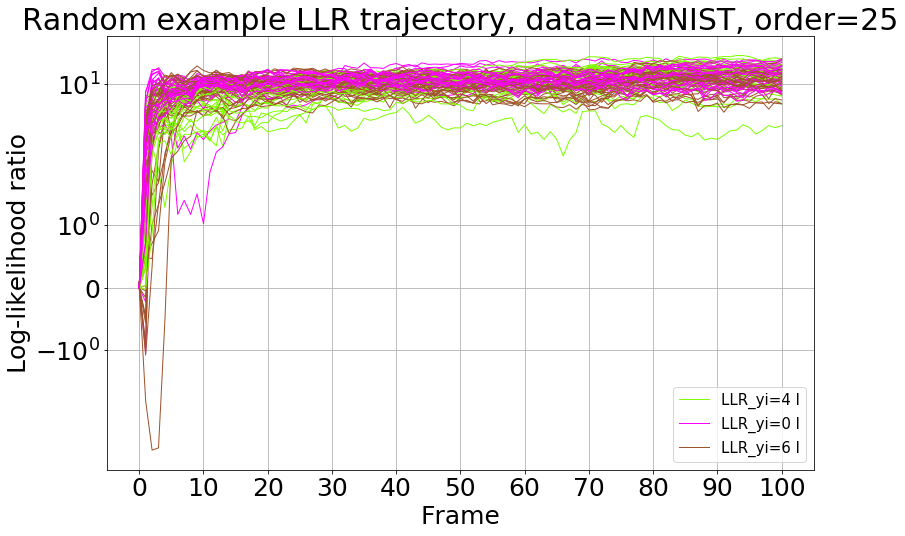

In [27]:
# Start plotting trajectory
######################################
# Parameters
x = [i for i in range(0, duration+1)]
title = "Random example LLR trajectory, data=NMNIST, order={}".format(order_sprt)
xlabel = "Frame"
ylabel = "Log-likelihood ratio"

# Size
plt.rcParams["font.size"] = 25
plt.figure(figsize=(13,8)) 

_tmp = set()
for itr_llrs, itr_label in zip(llrs_trj, labels_trj):
    itr_llrs = np.transpose(itr_llrs, [1, 0])
    itr_llrs = np.delete(itr_llrs, obj=itr_label, axis=0)
        # (num classes - 1, duration)
    for itr_trj in itr_llrs:
        y = np.append(0, itr_trj)
        
        # Color
        color = ls_color[itr_label]
        
        # Label
        if _tmp >= {itr_label}:
            plot_label = None
        else:
            _tmp.add(itr_label)
            plot_label = ls_plotLabel[itr_label]
        
        # Plot
        plt.plot(
            x, y, 
            color=color, 
            marker='o', 
            linewidth=1, 
            markersize=0,
            label=plot_label
            )
        cnt += 1

plt.xlabel(xlabel)
plt.ylabel(ylabel)        
plt.yscale("symlog")
plt.grid(True)
plt.legend(fontsize='15')
plt.title(title)
plt.xticks([i for i in range(0, duration + 1, 10)])
#plt.xlim(-0.1, 20.1)

plt.tight_layout()

# Save figure 
# plt.savefig(
#     "./traj_order{}.svg".format(order_sprt), 
#     format="svg", 
#     dpi=1200)

## 3-5. Positive LLR row with fixed $y_i$

- $\mathrm{LLR}_{y_{i}\, l}$, where $l \neq y_i = $ fixed.

In [28]:
num_trj = 100
plot_classes = [5] # specify a single class
shuffle = True

In [29]:
# Initialization
llrs_trj = llrs_all
labels_trj = labels_all

### Restrict classes
llrs_trj, labels_trj = restrict_classes(llrs_trj, labels_trj, plot_classes)

### Extract positive rows: shape change -> (batch, duration, num classes)
llrs_trj = extract_positive_row(llrs_trj, labels_trj)

# Shuffle (optional)
if shuffle:
    idx_perm = np.random.permutation(labels_trj.shape[0]) # randomly take some LLRs
    llrs_trj = tf.constant(llrs_trj.numpy()[idx_perm], dtype=tf.float32)
    labels_trj = tf.constant(labels_trj.numpy()[idx_perm], dtype=tf.int32)
    
# Pick some up
llrs_trj = llrs_trj[:num_trj].numpy()
labels_trj = labels_trj[:num_trj].numpy()

In [30]:
# Color definitions
ls_color = [
    "magenta",
    "darkviolet",
    "royalblue",
    "cyan",
    "chartreuse",
    "red",
    "sienna", 
    "darkorange",
    "black", 
    "olive"
]
#black, darkred, sienna, green, springgreen, darkslategrey, blue, darkviolet, magenta, red
ls_plotLabel =[
    "LLR_yi={} 0".format(plot_classes[0]),
    "LLR_yi={} 1".format(plot_classes[0]),
    "LLR_yi={} 2".format(plot_classes[0]),
    "LLR_yi={} 3".format(plot_classes[0]),
    "LLR_yi={} 4".format(plot_classes[0]),
    "LLR_yi={} 5".format(plot_classes[0]),
    "LLR_yi={} 6".format(plot_classes[0]),
    "LLR_yi={} 7".format(plot_classes[0]),
    "LLR_yi={} 8".format(plot_classes[0]),
    "LLR_yi={} 9".format(plot_classes[0]),] 

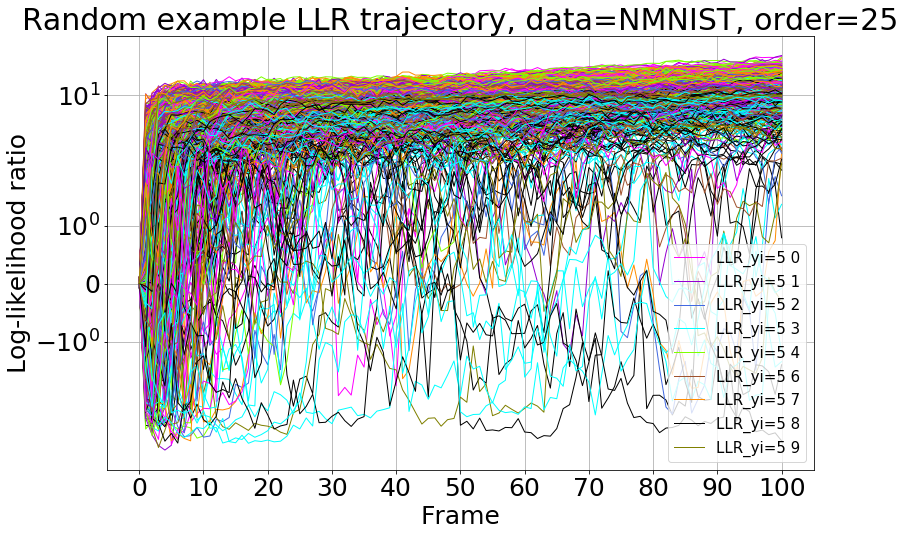

In [31]:
# Start plotting trajectory
######################################
# Parameters
x = [i for i in range(0, duration+1)]
title = "Random example LLR trajectory, data=NMNIST, order={}".format(order_sprt)
xlabel = "Frame"
ylabel = "Log-likelihood ratio"

# Size
plt.rcParams["font.size"] = 25
plt.figure(figsize=(13,8)) 

_tmp = set()
for itr_llrs, itr_label in zip(llrs_trj, labels_trj):
    itr_llrs = np.transpose(itr_llrs, [1, 0])
        # (num classes, duration)
    for itr_i, itr_trj in enumerate(itr_llrs):
        if itr_i == itr_label:
            continue # since llr = 0

        y = np.append(0, itr_trj)
        
        # Color
        color = ls_color[itr_i]
        
        # Label
        if _tmp >= {itr_i}:
            plot_label = None
        else:
            _tmp.add(itr_i)
            plot_label = ls_plotLabel[itr_i]
        
        # Plot
        plt.plot(
            x, y, 
            color=color, 
            marker='o', 
            linewidth=1, 
            markersize=0,
            label=plot_label
            )
        cnt += 1

plt.xlabel(xlabel)
plt.ylabel(ylabel)        
plt.yscale("symlog")
plt.grid(True)
plt.legend(fontsize='15')
plt.title(title)
plt.xticks([i for i in range(0, duration + 1, 10)])
#plt.xlim(-0.1, 20.1)

plt.tight_layout()

# Save figure 
# plt.savefig(
#     "./traj_order{}.svg".format(order_sprt), 
#     format="svg", 
#     dpi=1200)